In [2]:
import nltk
import re 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet


import warnings
warnings.filterwarnings('ignore')

In [3]:
# importing training and testing data 
corpus = pd.read_csv('Tweet Emotion Dataset.csv', names=["Tweet", "Emotion"], header=None)
corpus_test = pd.read_csv('test_dataset.csv', names=["Tweet", "Emotion"], header=None)

### Data Exploration 

In [4]:
corpus.head()

,Tweet,Emotion
0,@ZubairSabirPTI pls dont insult the word 'Molna',anger
1,@ArcticFantasy I would have almost took offens...,anger
2,@IllinoisLoyalty that Rutgers game was an abom...,anger
3,@CozanGaming that's what lisa asked before she...,anger
4,Sometimes I get mad over something so minuscul...,anger


In [5]:
corpus_test.head()

,Tweet,Emotion
0,At the point today where if someone says somet...,?
1,@CorningFootball IT'S GAME DAY!!!! T MIN...,?
2,This game has pissed me off more than any othe...,?
3,@spamvicious I've just found out it's Candice ...,?
4,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,?


In [6]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Tweet    347 non-null    object
 1   Emotion  347 non-null    object
dtypes: object(2)
memory usage: 5.5+ KB


In [7]:
corpus_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Tweet    3142 non-null   object
 1   Emotion  3142 non-null   object
dtypes: object(2)
memory usage: 49.2+ KB


**No null values are present. Fill NA not necessary**

In [8]:
corpus['Emotion'].value_counts()

fear       110
anger       84
joy         79
sadness     74
Name: Emotion, dtype: int64

<AxesSubplot:>

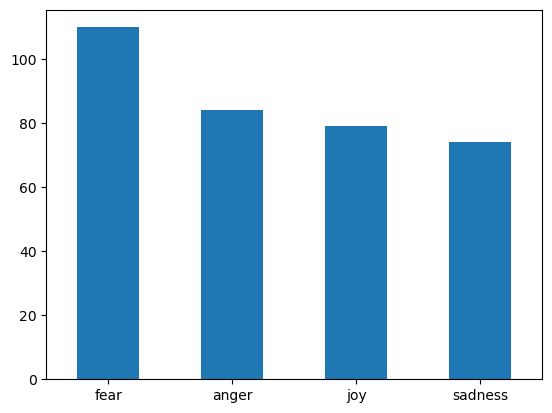

In [9]:
# visualizing label counts 
corpus['Emotion'].value_counts().plot(kind='bar', rot=360)

**The labels seem to be unbalanced, with 'fear' as the most frequent label** <br> 
Random oversampling will be completed to balance the datasets by randomly resampling with replacement tweets with categories 'anger', 'joy', and 'sadness' counts will be equal to the majority (fear) each having a frequency of 110

### Separating features and labels 

In [10]:
X = list(corpus['Tweet'])
y = corpus['Emotion']

print(len(X))
print(len(y))

347
347


### Creating custom text normalizer 

https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e


In [11]:
class TextNormalizer(BaseEstimator, TransformerMixin): 
    
    def __init__(self): 
        self.stopwords =set(stopwords.words('english')) 
        self.lemm=WordNetLemmatizer()
    
    def lower(self, document): 
        lower = document.lower()
        return lower
    
    def remove_url(self, document): 
        p1 = r"http\S+"
        rem_url = re.sub(p1, "", self.lower(document)) #matches text from string that contains 'http' and one or more occurances of any non-whitespace characters 
        return rem_url
    
    def remove_handle(self, document):
        p3 = r"@\S+"
        rem_handle = re.sub(p3, "", self.remove_url(document))
        return rem_handle
    
    def remove_punct(self, document): 
        p2 = r"[^\w\s]|\d|_" # matches text from string that does not contain a word or a whitespace character
        rem_punc = re.sub(p2, "", self.remove_handle(document))
        return rem_punc
    
    def remove_non_english(self, document):
    
        '''
        uses ascii characters to encode the string (ascii --> digits, upper & lower case english letters, special characters)
        if a character can't be encoded, it will be ignored, in this case removed
        when a character is encoded, it converts a string to a byte 
        to convert back to a string decode() is called 
        '''

        eng_text = self.remove_punct(document).encode("ascii", errors="ignore").decode()

        return eng_text
    
    def stopword_rem(self, document): 
        tokens = word_tokenize(self.remove_non_english(document))
        stop_rem = [w for w in tokens if w not in self.stopwords]
        return stop_rem
    
    def rem_one_word(self, document): 
        one_word = [w for w in self.stopword_rem(document) if len(w) > 2]
        return one_word
    
    def get_word_pos(self, word):
        tag=nltk.pos_tag([word])[0][1][0].upper()
        tag_dict={"J":wordnet.ADJ,
                 "N":wordnet.NOUN,
                 "V":wordnet.VERB,
                 "R":wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
        
    
    def lemmatizer(self,document):
        lemma_lst=[self.lemm.lemmatize(w, self.get_word_pos(w)) for w in self.rem_one_word(document)]
        #lemma_lst=[self.lemm.lemmatize(w) for w in self.rem_one_word(document)]
        return " ".join(lemma_lst)
    
    def fit(self, X, y=None):
        return self

    def transform(self, documents):
        for document in documents:
            yield self.lemmatizer(document)
    


        

### Code To Visualize the Normalized Text in a DF 

In [12]:
preprocess_pipe = Pipeline(steps = [ 
                            ('norm', TextNormalizer())])


In [13]:
preprocess_pipe.fit(X)

Pipeline(steps=[('norm', TextNormalizer())])

In [14]:
x = preprocess_pipe.transform(X)

In [15]:
X = list(x)
normalized_df = pd.DataFrame(X)
normalized_df

,0
0,pls dont insult word molna
1,would almost take offense actually snap
2,rutgers game abomination affront god man must ...
3,thats lisa ask start rag call heh
4,sometimes get mad something minuscule try ruin...
...,...
342,common app randomly log write last part colleg...
343,rather laugh rarest genius beautiful alliance ...
344,invest new film stop ask invest new film conce...
345,watch django unchained people may frown titter...


**Splitting data into train and test sets**

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

277
277
70
70


### Creating the Preprocessing Pipeline

In [17]:
pre_processing_pipe = Pipeline([
    ('norm', TextNormalizer()),
    ('vec', TfidfVectorizer())])

X_train = pre_processing_pipe.fit_transform(X_train)

In [18]:
X_train

<277x1307 sparse matrix of type '<class 'numpy.float64'>'
	with 2340 stored elements in Compressed Sparse Row format>

### Niave Bayes Multinomial Classifier 

Best for discrete vector feature inputs like value counts, but tf-idf factor counts may also work

In [19]:
from sklearn.naive_bayes import MultinomialNB

clf1 = MultinomialNB()
clf1.fit(X_train, y_train)

MultinomialNB()

**Evaluating Model**

1. Confusion Maxtrix

In [20]:
yhat1 = cross_val_predict(clf1, X_train, y_train, cv=10)
confusion_matrix(y_train, yhat1)

array([[27, 39,  1,  1],
       [ 2, 91,  0,  1],
       [ 4, 33, 22,  1],
       [10, 31,  0, 14]])

In [21]:
print(classification_report(y_train, yhat1))

              precision    recall  f1-score   support

       anger       0.63      0.40      0.49        68
        fear       0.47      0.97      0.63        94
         joy       0.96      0.37      0.53        60
     sadness       0.82      0.25      0.39        55

    accuracy                           0.56       277
   macro avg       0.72      0.50      0.51       277
weighted avg       0.68      0.56      0.53       277



### SGD Classifier

In [22]:
from sklearn.linear_model import SGDClassifier

clf2 = SGDClassifier()
clf2.fit(X_train, y_train)

SGDClassifier()

**Evaluating Model**

In [23]:
yhat2 = cross_val_predict(clf2, X_train, y_train, cv=10)
confusion_matrix(y_train, yhat2)

array([[44, 14,  2,  8],
       [ 6, 79,  3,  6],
       [ 7, 10, 39,  4],
       [11, 10,  2, 32]])

In [24]:
print(classification_report(y_train, yhat2))

              precision    recall  f1-score   support

       anger       0.65      0.65      0.65        68
        fear       0.70      0.84      0.76        94
         joy       0.85      0.65      0.74        60
     sadness       0.64      0.58      0.61        55

    accuracy                           0.70       277
   macro avg       0.71      0.68      0.69       277
weighted avg       0.71      0.70      0.70       277



### SVC Classifier

In [25]:
from sklearn.svm import SVC

clf3 = SVC()
clf3.fit(X_train, y_train)

SVC()

**Evaluating Model**

In [26]:
yhat3 = cross_val_predict(clf3, X_train, y_train, cv=10)
confusion_matrix(y_train, yhat3)

array([[12, 55,  0,  1],
       [ 2, 91,  0,  1],
       [ 0, 53,  7,  0],
       [ 1, 48,  0,  6]])

In [27]:
print(classification_report(y_train, yhat3))

              precision    recall  f1-score   support

       anger       0.80      0.18      0.29        68
        fear       0.37      0.97      0.53        94
         joy       1.00      0.12      0.21        60
     sadness       0.75      0.11      0.19        55

    accuracy                           0.42       277
   macro avg       0.73      0.34      0.31       277
weighted avg       0.69      0.42      0.34       277



### Decision Tree Classifier

In [28]:
from sklearn.tree import DecisionTreeClassifier

clf4 = DecisionTreeClassifier()
clf4.fit(X_train, y_train)

DecisionTreeClassifier()

**Evaluating Model**

In [29]:
yhat4 = cross_val_predict(clf4, X_train, y_train, cv=10)
confusion_matrix(y_train, yhat4)

array([[27, 35,  3,  3],
       [13, 72,  8,  1],
       [ 6, 23, 29,  2],
       [ 3, 27,  2, 23]])

In [30]:
print(classification_report(y_train, yhat4))

              precision    recall  f1-score   support

       anger       0.55      0.40      0.46        68
        fear       0.46      0.77      0.57        94
         joy       0.69      0.48      0.57        60
     sadness       0.79      0.42      0.55        55

    accuracy                           0.55       277
   macro avg       0.62      0.52      0.54       277
weighted avg       0.60      0.55      0.54       277



**The unbalanced dataset did not perform well for all cross-validated models.  Let's try oversampling to yeild better classification evaluations**

### Training Models with Balanced Dataset 

In [31]:
X = pre_processing_pipe.fit_transform(X)

In [32]:
X

<347x1480 sparse matrix of type '<class 'numpy.float64'>'
	with 2877 stored elements in Compressed Sparse Row format>

In [33]:
ros = RandomOverSampler(sampling_strategy='not majority')
X, y = ros.fit_resample(X, y)

In [34]:
y.value_counts()

anger      110
fear       110
joy        110
sadness    110
Name: Emotion, dtype: int64

In [35]:
print(X.shape[0])
print(len(y))


440
440


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print((X_train).shape[0])
print(len(y_train))
print((X_test).shape[0])
print(len(y_test))

352
352
88
88


In [37]:
models = [clf1, clf2, clf3, clf4]
for m in models:
    print(m, "\n")
    clf = m.fit(X_train, y_train)
    print("Evaluating model {m}".format(m=m))
    yhat = cross_val_predict(clf, X_train, y_train, cv=10)
    print(confusion_matrix(y_train, yhat))
    print(classification_report(y_train, yhat)) 

MultinomialNB() 

Evaluating model MultinomialNB()
[[70  3  1 11]
 [ 5 41 15 21]
 [ 6  3 66 11]
 [ 7  2  3 87]]
              precision    recall  f1-score   support

       anger       0.80      0.82      0.81        85
        fear       0.84      0.50      0.63        82
         joy       0.78      0.77      0.77        86
     sadness       0.67      0.88      0.76        99

    accuracy                           0.75       352
   macro avg       0.77      0.74      0.74       352
weighted avg       0.76      0.75      0.74       352

SGDClassifier() 

Evaluating model SGDClassifier()
[[67  9  1  8]
 [ 7 52  9 14]
 [ 5  7 68  6]
 [ 8  5  2 84]]
              precision    recall  f1-score   support

       anger       0.77      0.79      0.78        85
        fear       0.71      0.63      0.67        82
         joy       0.85      0.79      0.82        86
     sadness       0.75      0.85      0.80        99

    accuracy                           0.77       352
   macro avg   

**Based on the cross-validated scores for all 4 models, SGD Classifier performed the best.  This will be the model that will be used on the testing data** 

### Non-cross-validated Predictions for SGD Model 

In [38]:
yhat = clf2.predict(X_train)

In [39]:
confusion_matrix(y_train, yhat)

array([[82,  0,  0,  3],
       [ 0, 81,  0,  1],
       [ 0,  0, 86,  0],
       [ 0,  0,  0, 99]])

In [40]:
print(classification_report(y_train, yhat))

              precision    recall  f1-score   support

       anger       1.00      0.96      0.98        85
        fear       1.00      0.99      0.99        82
         joy       1.00      1.00      1.00        86
     sadness       0.96      1.00      0.98        99

    accuracy                           0.99       352
   macro avg       0.99      0.99      0.99       352
weighted avg       0.99      0.99      0.99       352



### Predicting Values on Test Set Using SGD Classifier 

In [41]:
yhat_test = clf2.predict(X_test)

In [42]:
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

       anger       0.90      0.76      0.83        25
        fear       0.77      0.82      0.79        28
         joy       0.86      0.75      0.80        24
     sadness       0.50      0.73      0.59        11

    accuracy                           0.77        88
   macro avg       0.76      0.76      0.75        88
weighted avg       0.80      0.77      0.78        88



**It seems that the SGD classifier overfit the train data.  This is evident when obeserving the classification report for the testing data, the accuracy decreased when passing the unseen testing data to the model.  Let's see if BERT word embeddings which takes context into account would yeild better testing evaluations**

## BERT Word Embedding Method 


In [43]:
X = list(corpus['Tweet'])
y = corpus['Emotion']

In [44]:
preprocess_pipe.fit(X)

Pipeline(steps=[('norm', TextNormalizer())])

In [45]:
x = preprocess_pipe.transform(X)

In [46]:
X = list(x)

In [1]:
from sentence_transformers import SentenceTransformer 
bert = SentenceTransformer('all-mpnet-base-v2')

In [47]:
bert_vec = bert.encode(X)
type(bert_vec)

numpy.ndarray

In [48]:
bert_vec.shape

(347, 768)

In [49]:
X = pd.DataFrame(bert_vec)

In [50]:
ros = RandomOverSampler(sampling_strategy='not majority')
X, y = ros.fit_resample(X, y)

In [51]:
y.value_counts()

anger      110
fear       110
joy        110
sadness    110
Name: Emotion, dtype: int64

In [52]:
print(X.shape[0])
print(len(y))

440
440


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print((X_train).shape[0])
print(len(y_train))
print((X_test).shape[0])
print(len(y_test))

352
352
88
88


In [54]:
models = [clf2, clf3, clf4]
for m in models:
    print(m, "\n")
    clf = m.fit(X_train, y_train)
    print("Evaluating model {m}".format(m=m))
    yhat = cross_val_predict(clf, X_train, y_train, cv=10)
    print(confusion_matrix(y_train, yhat))
    print(classification_report(y_train, yhat)) 

SGDClassifier() 

Evaluating model SGDClassifier()
[[59 11  6  9]
 [10 54  5 13]
 [ 4  5 80  5]
 [ 8 12  7 64]]
              precision    recall  f1-score   support

       anger       0.73      0.69      0.71        85
        fear       0.66      0.66      0.66        82
         joy       0.82      0.85      0.83        94
     sadness       0.70      0.70      0.70        91

    accuracy                           0.73       352
   macro avg       0.73      0.73      0.73       352
weighted avg       0.73      0.73      0.73       352

SVC() 

Evaluating model SVC()
[[63 10  5  7]
 [10 58  3 11]
 [ 5  5 78  6]
 [ 4 16  8 63]]
              precision    recall  f1-score   support

       anger       0.77      0.74      0.75        85
        fear       0.65      0.71      0.68        82
         joy       0.83      0.83      0.83        94
     sadness       0.72      0.69      0.71        91

    accuracy                           0.74       352
   macro avg       0.74      0.74  

**When using BERT context aware vectorization, the SVC model performs best, this will be the model that will be used on the test set**

### Non-Cross Validation Predictions for SCV Classifier 

In [55]:
yhat_bert = clf3.predict(X_train)

In [56]:
clf3.score(X_train, y_train)

0.9914772727272727

In [57]:
print(confusion_matrix(y_train, yhat_bert))
print(classification_report(y_train, yhat_bert))

[[85  0  0  0]
 [ 0 82  0  0]
 [ 0  0 94  0]
 [ 1  2  0 88]]
              precision    recall  f1-score   support

       anger       0.99      1.00      0.99        85
        fear       0.98      1.00      0.99        82
         joy       1.00      1.00      1.00        94
     sadness       1.00      0.97      0.98        91

    accuracy                           0.99       352
   macro avg       0.99      0.99      0.99       352
weighted avg       0.99      0.99      0.99       352



### Predicting the Test Set 

In [58]:
yhat_bert_test = clf3.predict(X_test)

In [59]:
clf3.score(X_test, y_test)

0.875

In [60]:
print(confusion_matrix(y_test, yhat_bert_test))
print(classification_report(y_test, yhat_bert_test))

[[21  0  0  4]
 [ 1 24  2  1]
 [ 0  1 15  0]
 [ 1  1  0 17]]
              precision    recall  f1-score   support

       anger       0.91      0.84      0.87        25
        fear       0.92      0.86      0.89        28
         joy       0.88      0.94      0.91        16
     sadness       0.77      0.89      0.83        19

    accuracy                           0.88        88
   macro avg       0.87      0.88      0.88        88
weighted avg       0.88      0.88      0.88        88



**Based on the above model evaluations, SVC with BERT vectorization techniques and SGD with tf-idf vectorization techniques produced similar evaluation results.  However, deploying a model to be used consistently for classification may require a more context-aware analysis.  Therefore, the SVC model with BERT vectorixation techniques will be used to classify the unlabelled dataset** 

In [61]:
unlabelled_tweets = list(corpus_test["Tweet"])
len(unlabelled_tweets)

3142

In [63]:
unlabelled_tweets = preprocess_pipe.transform(unlabelled_tweets)
unlabelled_tweets

<generator object TextNormalizer.transform at 0x7fb0cf9c8ba0>

In [64]:
unlabelled_tweets = list(unlabelled_tweets)
len(unlabelled_tweets)

3142

In [69]:
bert_vec_test = bert.encode(unlabelled_tweets)

In [ ]:
type(bert_vec_test)

In [66]:
y_pred_test = clf3.predict(bert_vec_test)
#print(y_pred_test)

In [73]:
bert_df = pd.DataFrame({
    "Tweet" : corpus_test['Tweet'], 
    "Emotion": y_pred_test
})

In [74]:
bert_df.head()

,Tweet,Emotion
0,At the point today where if someone says somet...,fear
1,@CorningFootball IT'S GAME DAY!!!! T MIN...,sadness
2,This game has pissed me off more than any othe...,anger
3,@spamvicious I've just found out it's Candice ...,joy
4,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,fear


In [76]:
bert_df.to_excel(r'\Users\victoriavillani\Desktop\bert_labelled_test_data.xlsx', index=False)